# Basic Tutorial on the quil Instruction Set. We build low level quantum programs with quil instructions on classical and quantum registers. 

This notebook assumes that pyQuil has already been set up in this system.

In [1]:
%matplotlib inline

### Define bra and ket newcommands. Edit below cell to check commands

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$

$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

### Testing the Environment

In [2]:
from pyquil.quil import Program
from pyquil.api import QVMConnection
from pyquil.gates import CNOT, H

qvm = QVMConnection()
p = Program(H(0), CNOT(0, 1))

wf = qvm.wavefunction(p)
print(wf)

(0.7071067812+0j)|00> + (0.7071067812+0j)|11>


In [3]:
def execute(quil_program, trials=100, silent=False, raw=False):
    """
    Thin function that takes a low-level Quil program and returns the
    resulting probability distribution.
    """

    qvm = QVMConnection()
    results = qvm.run(Program(quil_program), trials=trials)
    results = list(map(tuple, results))

    if not silent:
        observed_results = set(results)
        for result in sorted(observed_results):
            bitstring = ''.join(reversed(list(map(str, result))))
            print(f'|{bitstring}> state: {results.count(result)/len(results)} [{results.count(result)}/{len(results)}]')
        if raw:
            print(f'Results: {results}')

def plot(quil_program):
    qvm = QVMConnection()
    return qvm.wavefunction(Program(quil_program)).plot()   

### Measuring Qubits

```
MEASURE <qubitNumber> [<ClassicalRegisterNumber>]
``` 

In [4]:
execute("""
MEASURE 0 [0]
""")

|0> state: 1.0 [100/100]


### Applying basic gates

In [5]:
execute("""
X 0
X 1
MEASURE 0 [0]
MEASURE 1 [1]
""")

|11> state: 1.0 [100/100]


In [6]:
execute("""
H 0
H 1
MEASURE 0 [0]
MEASURE 1 [1]
""")

|00> state: 0.24 [24/100]
|10> state: 0.19 [19/100]
|01> state: 0.26 [26/100]
|11> state: 0.31 [31/100]


In [7]:
execute("""
H 1
MEASURE 0 [1]
MEASURE 1 [0]
""")

|00> state: 0.53 [53/100]
|01> state: 0.47 [47/100]


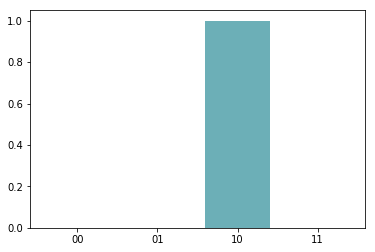

In [8]:
plot("""
H 1
MEASURE 0 [1]
MEASURE 1 [0]
""")

To ensure that you get a plot showing the expected sample distribution
measurement must be deferred. See the plot below

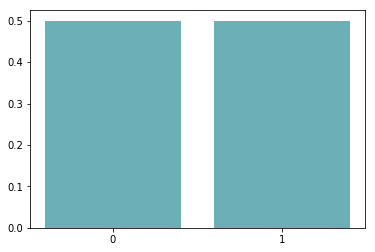

In [9]:
plot("""
H 1
""")

### Quantum Die - 8 sided

A fair die has equal probability of turning up in any of the n sides. The quantum equivalent of that is a system that is in an equal superposition of 8 states. For 8 states, we need $log_2(8)=3$ qubits. For this purpose we use the H gate.

In [10]:
execute("""
H 0
H 1
H 2
MEASURE 0 [0]
MEASURE 1 [1]
MEASURE 2 [2]
""", trials=100000)

|000> state: 0.12599 [12599/100000]
|100> state: 0.12553 [12553/100000]
|010> state: 0.12559 [12559/100000]
|110> state: 0.12242 [12242/100000]
|001> state: 0.12497 [12497/100000]
|101> state: 0.12598 [12598/100000]
|011> state: 0.12359 [12359/100000]
|111> state: 0.12593 [12593/100000]


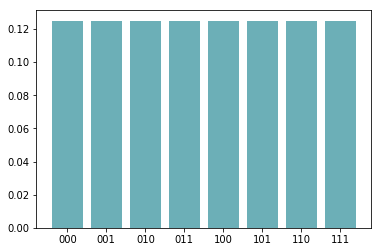

In [11]:
plot("""
H 0
H 1
H 2
""")

### 2-qubit Gates

The first 2 qubit gate we deal with is CNOT. The syntax is as follows:
```
CNOT <control_qubit> <apply_qubit>
```

Basic circuit that applies NOT to Qubit 1 if the Qubit 0 was originally $\ket{0}$

In [12]:
execute("""
X 0
CNOT 0 1
X 0
MEASURE 0 [0]
MEASURE 1 [1]
""")

|10> state: 1.0 [100/100]


### Entanglement

Create the state $\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})$

In [13]:
execute("""
H 0
CNOT 0 1
MEASURE 0 [0]
MEASURE 1 [1]
""", trials=100000)

|00> state: 0.49784 [49784/100000]
|11> state: 0.50216 [50216/100000]


Create the state $\frac{1}{\sqrt{2}}(\ket{01}+\ket{10})$

In [14]:
execute("""
H 0
CNOT 0 1
X 0
MEASURE 0 [0]
MEASURE 1 [1]
""", trials=100000)

|10> state: 0.5001 [50010/100000]
|01> state: 0.4999 [49990/100000]


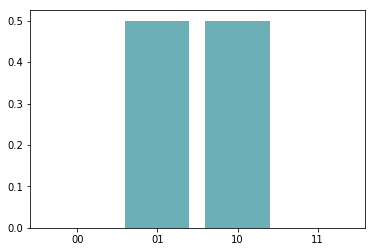

In [15]:
plot("""
H 0
CNOT 0 1
X 0
""")

### 7-Sided Die

In order to create a 7-sided die, we again need $\lceil log_2(7)\rceil=3 $ qubits. We apply $H$ on all three qubits and then measure them. If the state turns out to be $ \ket{000}$, we discard it, not add it to our output statistics and run the program again. We then end up with an equal probability distribution of $\ket{abc} $ where $ a,b,c \in \{0,1\}$ and $\ket{abc}\neq\ket{000}$

In [16]:
execute("""
LABEL @START
H 0
H 1
H 2
MEASURE 0 [0]
MEASURE 1 [1]
MEASURE 2 [2]
JUMP-WHEN @FINISH [0]
JUMP-WHEN @FINISH [1]
JUMP-WHEN @FINISH [2]
JUMP @START
LABEL @FINISH
""", trials=100000)

|100> state: 0.14335 [14335/100000]
|010> state: 0.14252 [14252/100000]
|110> state: 0.14139 [14139/100000]
|001> state: 0.14193 [14193/100000]
|101> state: 0.14335 [14335/100000]
|011> state: 0.1445 [14450/100000]
|111> state: 0.14296 [14296/100000]


### Teleportation

The circuit below shows the Teleportation protocol. 
(Image source: Mike & Ike)

<img src="Teleportation.png">

The first instruction in the code below is for setting the state to teleport.
The two instructions below that prepare the entangled qubit pair shared by Alice and Bob.

In [17]:
execute("""
H 0

H 1
CNOT 1 2
CNOT 0 1
H 0
MEASURE 0 [0]
MEASURE 1 [1]
JUMP-WHEN @CASE1 [1]
LABEL @FORK2
JUMP-WHEN @CASE2 [0]
JUMP @FINISH
LABEL @CASE1
X 2
JUMP @FORK2
LABEL @CASE2
Z 2
JUMP @FINISH
LABEL @FINISH
MEASURE 2 [2]
""", trials=10000)

|000> state: 0.1264 [1264/10000]
|100> state: 0.1347 [1347/10000]
|010> state: 0.1303 [1303/10000]
|110> state: 0.1231 [1231/10000]
|001> state: 0.1237 [1237/10000]
|101> state: 0.1213 [1213/10000]
|011> state: 0.1206 [1206/10000]
|111> state: 0.1199 [1199/10000]


## Controlled Gates

Given a matrix U, build a single qubit controlled version of U

In [18]:
import numpy as np
def controlled(m):
    """
    Make a one-qubit-controlled version of a matrix.
    :param m: (numpy.ndarray) A matrix.
    :return: A controlled version of that matrix.
    """
    rows, cols = m.shape
    assert rows == cols
    n = rows
    I = np.eye(n)
    Z = np.zeros((n, n))
    controlled_m = np.bmat([[I, Z],
                            [Z, m]])
    return controlled_m

**Example** - Build a CCNOT (Toffoli) given a CNOT

In [19]:
U=np.mat('1,0,0,0;0,1,0,0;0,0,0,1;0,0,1,0');
gate_matrix=np.array(controlled(U))

In [20]:
from pyquil.gates import *
p=Program().defgate("Control-U", gate_matrix)
p.inst(X(0))
p.inst(X(1))
p.inst(("Control-U", 0, 1, 2)).measure(2, 2)
print(p)

DEFGATE Control-U:
    1.0, 0, 0, 0, 0, 0, 0, 0
    0, 1.0, 0, 0, 0, 0, 0, 0
    0, 0, 1.0, 0, 0, 0, 0, 0
    0, 0, 0, 1.0, 0, 0, 0, 0
    0, 0, 0, 0, 1.0, 0, 0, 0
    0, 0, 0, 0, 0, 1.0, 0, 0
    0, 0, 0, 0, 0, 0, 0, 1.0
    0, 0, 0, 0, 0, 0, 1.0, 0

X 0
X 1
Control-U 0 1 2
MEASURE 2 [2]



## Any $n>2$ Sided Die

In [21]:
import numpy as np
from pyquil.quil import Program
from pyquil.api import QVMConnection
from pyquil.gates import CNOT, H
qvm = QVMConnection()


def any_die(n):
    m=int(np.ceil(np.log(n)/np.log(2)))
    die_prog = Program()

    while (True):
        die_prog.inst(RESET)
        for qubit in range(m):
            die_prog.inst(H(qubit))
        die_prog.measure_all()
        results = qvm.run(die_prog, trials=1)
        binary_string = ''
        for temp in results[0]:
            binary_string+=str(temp)
        die_result=int(binary_string, 2)
        if (die_result>n-1):
            continue
        else:
            return die_result

In [22]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(any_die, n=(2,10));

interactive(children=(IntSlider(value=6, description='n', max=10, min=2), Output()), _dom_classes=('widget-int…